# Persist Benchmarks

In [1]:
# select measurement file
files = [
    "data/2025-03-13 16-17-54 persist.json",
    "data/2025-03-13 08-27-11 get.json", # for persistent storage benchmarks
]

# plot settings
show_error_bar = False
unit = "ms"
unit_joule = "mJ"


scale = 0.5

volt = 3.3
amps = 40e-3
wattage = volt * amps

print("Wattage:", wattage)

Wattage: 0.132


In [2]:
# parse data
import json

raw_data = []
for file_name in files:
    with open(file_name) as file:
        raw_data.extend(json.load(file))

In [3]:
from util.convert import convert_datasets
import pandas as pd

storage = convert_datasets(
    raw_data,
    "Storage",
    [("persistent_storage_write", "Storage Write")],
    ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"],
    unwrapped=show_error_bar
)

baseline = convert_datasets(
    raw_data,
    "Persist",
    [("max_dirty_persist_latency_dirty_size", "Dirty Size"), ("max_dirty_persist_latency_buffer_size", "Buffer Size")],
    ["mean", "min", "max", "options.dirty_size", "options.buffer_size", "options.ram_overhead", "machine_name", "cold_start", "repetitions"],
    unwrapped=show_error_bar
)

wcet = convert_datasets(
    raw_data,
    "Locked WCET",
    [
        ("storage_locked_wcet", "Locked WCET"),
        ("resident_object_manager_1_locked_wcet", "Locked WCET"),
        ("resident_object_manager_2_locked_wcet", "Locked WCET"),
        ("resident_object_manager_3_locked_wcet", "Locked WCET"),
        ("resident_object_manager_4_locked_wcet", "Locked WCET"),
        ("object_manager_1_locked_wcet", "Locked WCET"),
        ("resident_object_metadata_1_locked_wcet", "Locked WCET"),
    ],
    ["mean", "min", "max", "options.variant", "options.buffer_size", "options.object_size", "machine_name", "cold_start", "repetitions"],
    unwrapped=show_error_bar
)

dataset = pd.concat([storage, baseline, wcet])
dataset.head()

[{'mean': 535.02, 'min': 534, 'max': 598, 'options.object_size': 0, 'options.persistent_storage_module': 'vnv_heap::modules::persistent_storage::sliced::SlicedStorageModule<4, spi_fram_storage::mb85rs4mt_fram_storage::MB85RS4MTFramStorageModule>', 'bench_name': 'persistent_storage_write', 'machine_name': 'esp32c3', 'cold_start': 0, 'repetitions': 100, 'ticks_per_ms': 16000}, {'mean': 5677.71, 'min': 5625, 'max': 10865, 'options.object_size': 4, 'options.persistent_storage_module': 'vnv_heap::modules::persistent_storage::sliced::SlicedStorageModule<4, spi_fram_storage::mb85rs4mt_fram_storage::MB85RS4MTFramStorageModule>', 'bench_name': 'persistent_storage_write', 'machine_name': 'esp32c3', 'cold_start': 0, 'repetitions': 100, 'ticks_per_ms': 16000}, {'mean': 6876.63, 'min': 6824, 'max': 12064, 'options.object_size': 8, 'options.persistent_storage_module': 'vnv_heap::modules::persistent_storage::sliced::SlicedStorageModule<4, spi_fram_storage::mb85rs4mt_fram_storage::MB85RS4MTFramStorage

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms,dataset_type,benchmark_title,benchmark_id,options.dirty_size,options.buffer_size,options.ram_overhead,options.variant
0,535.02,534,598,0.0,esp32c3,0,100,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN,NaN,NaN
1,5677.71,5625,10865,4.0,esp32c3,0,100,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN,NaN,NaN
2,6876.63,6824,12064,8.0,esp32c3,0,100,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN,NaN,NaN
3,8117.20,8064,13305,12.0,esp32c3,0,100,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN,NaN,NaN
4,9358.01,9305,14546,16.0,esp32c3,0,100,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN,NaN,NaN


In [4]:
# update the metrics in the following as we do not persist the datastructures of vNVHeaps explicitly in our benchmarks

ram_overhead = dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "options.ram_overhead"]
assert(len(ram_overhead.unique()) == 1)
ram_overhead = ram_overhead.unique()[0]

# add the ram overhead to the buffer size and the dirty size (we want to include it to the RAM we manage and need to persist)
dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "options.buffer_size"] += ram_overhead
dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "options.dirty_size"] += ram_overhead

# add the latency it takes to persist the amount of bytes that is equal to the ram overhead
mean = dataset.loc[(dataset["benchmark_id"] == "persistent_storage_write") & (dataset["options.object_size"] == ram_overhead), "mean"].iloc[0]
min = dataset.loc[(dataset["benchmark_id"] == "persistent_storage_write") & (dataset["options.object_size"] == ram_overhead), "min"].iloc[0]
max = dataset.loc[(dataset["benchmark_id"] == "persistent_storage_write") & (dataset["options.object_size"] == ram_overhead), "max"].iloc[0]

dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "mean"] += mean
dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "min"] += min
dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "max"] += max

In [5]:
from util.convert import display_dataset_infos

display_dataset_infos(dataset)

min        33.438750
max    159097.075625
Name: mean, dtype: float64

min     4216.488125
max    79378.426250
Name: mean, dtype: float64

min     9602.401875
max    39506.425625
Name: mean, dtype: float64

min    178.948125
max    445.627500
Name: mean, dtype: float64

In [6]:
# add lock wcet to
baseline["mean"] += wcet["mean"].max()
baseline["min"] += wcet["min"].max()
baseline["max"] += wcet["max"].max()
 

In [7]:
from util.convert import display_dataset_infos

display_dataset_infos(dataset)

min        33.438750
max    159097.075625
Name: mean, dtype: float64

min     4216.488125
max    79378.426250
Name: mean, dtype: float64

min     9602.401875
max    39506.425625
Name: mean, dtype: float64

min    178.948125
max    445.627500
Name: mean, dtype: float64

In [8]:
# convert all numbers to joule
dataset["mean"] *= wattage
dataset["min"] *= wattage
dataset["max"] *= wattage

In [9]:
from util.convert import display_dataset_infos

display_dataset_infos(dataset)

min        4.413915
max    21000.813982
Name: mean, dtype: float64

min      556.576433
max    10477.952265
Name: mean, dtype: float64

min    1267.517047
max    5214.848182
Name: mean, dtype: float64

min    23.621153
max    58.822830
Name: mean, dtype: float64

In [10]:
from util.convert import scale_data
from IPython.display import HTML, display

scaled = scale_data(dataset.copy(), unit)
scaled["options.object_size"] = scaled["options.object_size"]/1024
scaled["options.dirty_size"] = scaled["options.dirty_size"]/1024
scaled["options.buffer_size"] = scaled["options.buffer_size"]/1024
scaled = scaled[(scaled["options.object_size"] % scale == 0) | (scaled["options.dirty_size"] % scale == 0) | (scaled["options.buffer_size"] % scale == 0)].copy()

scaled.loc[scaled["benchmark_id"] == "persistent_storage_write", "mean"] = scaled[scaled["benchmark_id"] == "persistent_storage_write"]["mean"].max()

for (id_left, left_opt, id_right) in [("max_dirty_persist_latency_dirty_size", "options.dirty_size", "persistent_storage_write"), ("max_dirty_persist_latency_buffer_size", "options.buffer_size", "persistent_storage_write")]:
    left = scaled[scaled["benchmark_id"] == id_left]
    right = scaled[scaled["benchmark_id"] == id_right]
    title_left = left["benchmark_title"].unique()[0]
    title_right = right["benchmark_title"].unique()[0]
    display(HTML(f"<b>{title_left} - {title_right}</b>"))

    res = []
    for size in left[left_opt].unique():
        if size % scale != 0:
            continue
        a = left[left[left_opt] == size]["mean"].iloc[0]
        b = right[right["options.object_size"] == size]["mean"].iloc[0]
        res.append((size, a,b,(100 * a)/b - 100, (100 * b)/a - 100))
    
    d = pd.DataFrame(res, columns=["Object size", f"{title_left} [{unit_joule}]", f"{title_right} [{unit_joule}]", "% Worse", "% Better"])

    display(d)
    print("Stats:")
    display(d.describe())

,Object size,Dirty Size [mJ],Storage Write [mJ],% Worse,% Better
0,0.5,1.266418,21.000814,-93.969672,1558.284461
1,1.0,2.579551,21.000814,-87.716901,714.126796
2,1.5,3.892792,21.000814,-81.463612,439.479439
3,2.0,5.205925,21.000814,-75.210840,303.402137
4,2.5,6.519165,21.000814,-68.957560,222.139629
5,3.0,7.833322,21.000814,-62.699911,168.095876
6,3.5,9.150894,21.000814,-56.426005,129.494681
7,4.0,10.477952,21.000814,-50.106923,100.428609


Stats:


,Object size,Dirty Size [mJ],Storage Write [mJ],% Worse,% Better
count,8.000000,8.000000,8.000000,8.000000,8.000000
mean,2.250000,5.865752,21.000814,-72.068928,454.431453
std,1.224745,3.221441,0.000000,15.339599,489.287532
min,0.500000,1.266418,21.000814,-93.969672,100.428609
25%,1.375000,3.564482,21.000814,-83.026935,158.445577
50%,2.250000,5.862545,21.000814,-72.084200,262.770883
75%,3.125000,8.162715,21.000814,-61.131435,508.141278
max,4.000000,10.477952,21.000814,-50.106923,1558.284461


,Object size,Buffer Size [mJ],Storage Write [mJ],% Worse,% Better
0,0.5,1.267517,21.000814,-93.964438,1556.846669
1,1.0,2.583294,21.000814,-87.699078,712.947179
2,1.5,3.899069,21.000814,-81.433725,438.610991
3,2.0,5.214848,21.000814,-75.168352,302.711896
4,2.5,5.207486,21.000814,-75.203409,303.281240
5,3.0,5.205928,21.000814,-75.210828,303.401933
6,3.5,5.205928,21.000814,-75.210827,303.401926
7,4.0,5.205925,21.000814,-75.210841,303.402157


Stats:


,Object size,Buffer Size [mJ],Storage Write [mJ],% Worse,% Better
count,8.000000,8.000000,8.000000,8.000000,8.000000
mean,2.250000,4.223749,21.000814,-79.887687,528.075499
std,1.224745,1.529699,0.000000,7.283999,439.692637
min,0.500000,1.267517,21.000814,-93.964438,302.711896
25%,1.375000,3.570125,21.000814,-83.000063,303.371755
50%,2.250000,5.205927,21.000814,-75.210835,303.402045
75%,3.125000,5.206318,21.000814,-75.208973,507.195038
max,4.000000,5.214848,21.000814,-75.168352,1556.846669


# Final Plot

In [11]:
from util.plot import set_theme
# palette = ["#c2df23", "#51c56a"]
palette = set_theme(colors=2)

scaled_dataset = dataset.copy()
scaled_dataset["options.object_size"] = scaled_dataset["options.object_size"]/1024
scaled_dataset["options.dirty_size"] = scaled_dataset["options.dirty_size"]/1024

storage_dataset = scaled_dataset[(scaled_dataset["benchmark_id"] == "persistent_storage_write") & (scaled_dataset["options.object_size"] <= 4) & (scaled_dataset["options.object_size"] >= scale) & (scaled_dataset["options.object_size"] % scale == 0)].copy()
storage_dataset["max"] = storage_dataset["max"].max()

plot_data = [{
    "name": "Unmanaged RAM",
    "x": "options.object_size",
    "y": "max",
    "marker": "o",
    "use_edge_color": True,
    "data": storage_dataset,
},{
    "name": "vNV-Heap",
    "x": "options.dirty_size",
    "y": "max",
    "marker": "X",
    "data": scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size") & (scaled_dataset["options.dirty_size"] % scale == 0)],
}]
buf_size = scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size") & (scaled_dataset["options.dirty_size"] % scale == 0)]["options.buffer_size"]
assert(len(buf_size.unique()) == 1)
buf_size = buf_size.unique()[0] / 1024

options1 = {
    "data": plot_data,
    "scale": unit,
    "x_label": "Dirty Limit [KiB]",
    "y_label": f"Energy [{unit_joule}]",
    "width": 1,
    "height": 0.25,
    "title": f"(a) RAM Limit: {int(buf_size)}KiB",
    "palette": palette
}

In [12]:
scale = 0.5
limit = 4

scaled_dataset = dataset.copy()
scaled_dataset["options.object_size"] /= 1024
scaled_dataset["options.buffer_size"] /= 1024

plot_data = [{
    "name": "",
    "x": "options.object_size",
    "y": "max",
    "marker": "o",
    "use_edge_color": True,
    "data": scaled_dataset[(scaled_dataset["benchmark_id"] == "persistent_storage_write") & (scaled_dataset["options.object_size"] <= limit) & (scaled_dataset["options.object_size"] >= scale) & (scaled_dataset["options.object_size"] % scale == 0)],
},{
    "name": "",
    "x": "options.buffer_size",
    "y": "max",
    "marker": "X",
    "data": scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (scaled_dataset["options.buffer_size"] % scale == 0)],
}]

dirty_size = scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (scaled_dataset["options.buffer_size"] % scale == 0)]["options.dirty_size"]
print(dirty_size)
dirty_size = dirty_size.max() / 1024

options2 = {
    "data": plot_data,
    "scale": unit,
    "x_label": "RAM Limit [KiB]",
    "y_label": f"Energy [{unit_joule}]",
    "width": 1,
    "height": 0.25,
    "title": f"(b) Dirty Limit: {int(dirty_size)}KiB",
    "palette": palette
}

0       512.0
16     1024.0
32     1536.0
48     2048.0
64     2048.0
80     2048.0
96     2048.0
112    2048.0
Name: options.dirty_size, dtype: float64


/home/markus/Documents/vnv_heap/evaluation/util/plot.py:209: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ncol = len(ax.legend().get_lines())


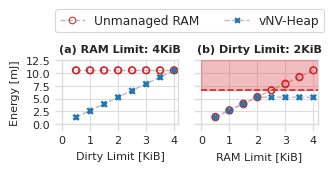

In [13]:
from util import convert
from util.plot import plot_lines, save_plot
import matplotlib.pyplot as plt

axes = plot_lines([options1, options2])

offset_multiplier = 0.2
scaled = convert.scale_data(scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (scaled_dataset["options.buffer_size"] % scale == 0)], unit)
#line = scaled["mean"].max() + scaled["mean"].max() * offset_multiplier
line = convert.scale_data(scaled_dataset[(scaled_dataset["benchmark_id"] == "persistent_storage_write") & (scaled_dataset["options.object_size"] == 2.5)], scale=unit)["mean"].iloc[0]

limit2 = (convert.scale_data(scaled_dataset[(scaled_dataset["benchmark_id"] == "persistent_storage_write") & (scaled_dataset["options.object_size"] <= limit)], unit))["mean"].max()
limit2 = 12.5

axes[1].axhline(line, ls='--', color=palette[0], zorder=20)
axes[1].set_ylim(bottom=0, top=limit2)
axes[1].axhspan(line, limit2, alpha=0.3, color=palette[0],zorder=10)
axes[0].legend(
    loc = "lower center",
    bbox_to_anchor=(1.1, 1.3 + 0.05),
    ncol=2,
    title=None,
    frameon=True
)
axes[1].get_legend().remove()

for ax in axes:
    ax.set_xticks([0,1,2,3,4])
    ax.set_xlim(0,4.15)
    ax.set_yticks([0,2.5,5,7.5,10,12.5])

save_plot("persist", False)